# 放射板への熱入力量の推測

main_target.py に準拠した notebook。動作チェック用。

In [1]:
import numpy as np
from astropy.coordinates import get_sun, SkyCoord, Galactic, CartesianRepresentation, TEME, ICRS
import astropy.units as u

from jasmine_orbit.OrbitAttitude import prepare_orbit, detect_ascending_nodes, load_target_coordinates, orbattitude, compute_fraction_between_nodes, compute_thermal_fraction_per_orbit, horizon_angle, thermal_input_per_orbit
from jasmine_orbit.OrbitTool import get_refdate

import seaborn as sns
sns.set_context("talk")

各種定数は config/settings_example.py を書き換えて設定する。デフォルト値は src/jasmine_orbit/defaults.py 参照。

In [2]:
import os
os.chdir("../") # for config

In [3]:
from config.settings_example import CONFIG

計算設定は以下で指定する。

In [4]:
args = {
    '-s': False, #春分点を基準
    '-a': True, #秋分点を基準
    '-p':  90., #基準日からの計算開始日(この日を含む)
    '-w':  0.2, #計算期間(日)
#    '-o': False, #グラフ出力
#    '-v': False, #3D画面出力
    '-t': "GJ 486", #target name
    '-m': 1., #time step in minutes [default: 1]
        }

軌道計算、ターゲットの読み込み、各種角度・ベクトルの計算

In [5]:
# main_target    

results, inclination_deg, (tle1, tle2), start_date, days_calc, altitude = prepare_orbit(args, config=CONFIG)
ref_date_spring, ref_date_autumn = get_refdate()

#time_an = detect_ascending_nodes(results)

target_name = args['-t']
print(target_name)
if target_name == 'GC':
    skycoord_target = SkyCoord(l=0 * u.degree, b=0 * u.degree, frame=Galactic)
else:
    try:
        skycoord_target, target_data = load_target_coordinates(target_name, config=CONFIG)
        #skycoord_target = SkyCoord(ra= (skycoord_target.ra.degree + 180)%360 * u.degree, dec=-skycoord_target.dec.degree * u.degree, frame=ICRS)
        print(skycoord_target)
    except ValueError as exc:
        print(exc)
    print(target_data)

times, Sat, toSun, toTgt, toSat, SatTgt, SunTgt, SatX, SatY, SatZ,\
    SatZSun, SatXSun, SatYSun, SatprojTgt, toSatZn, toSatAz, BarytoSat = orbattitude(results, skycoord_target, config=CONFIG)

from jasmine_orbit.GraphOrbit import get_true_segments
mask_tgt = (SatTgt <= CONFIG.OBSERVATION_ANGLE_MAX_DEG) 
obs_start_idx = get_true_segments(mask_tgt)
time_an = [times[idx[0]] for idx in obs_start_idx]


基準日 2030/09/22 15:00:00 (UTC) 
開始日 2030/12/21 15:00:00 (UTC)
計算時間 0.2 days
衛星高度: 600 km
軌道傾斜角: 97.7876 度
平均運動: 14.89338980 回/日
TLE :
 1 00000U 30001A   30001.50000000  .00000000  00000-0  00000-0 0  9991 
 2 00000 097.7876 191.6240 0000001 000.0000 090.0000 14.89338979995102
GJ 486
<SkyCoord (ICRS): (ra, dec) in deg
    (191.981531, 9.7494181)>
     name  JASMINE S/N  Npl_known          ra       dec       elon      elat  \
9  GJ 486         24.0        1.0  191.981531  9.749418  187.11208  13.69483   

    logL  logL_calc      M  Merr1  Merr2  Hwmag    P_in  Perr_in1  Perr_in2  \
9 -1.917     -1.767  0.323  0.015 -0.015  7.125  30.382     0.062     0.062   

    P_out  Perr_out1  Perr_out2  
9  54.393      0.111      0.111  


閾値の設定

In [6]:
sun_min, sun_max = CONFIG.THERMAL_SUN_ANGLE_RANGE_DEG
mask_obs = (SatTgt <= CONFIG.OBSERVATION_ANGLE_MAX_DEG) & (sun_min <= SatZSun) & (SatZSun <= sun_max)
index_obs = np.where(mask_obs)[0]

mask_thermal = (np.abs(toSatAz) <= CONFIG.THERMAL_Az_MAX_DEG) & (toSatZn >= CONFIG.THERMAL_Zn_MAX_DEG) 
thermal_indices = np.where(mask_thermal)[0]

# define thermal input with depending on phi(Az), theta(Zn)
alpha = horizon_angle(config=CONFIG)
thermal_input = np.cos(np.deg2rad(toSatAz)) * np.cos(np.pi - (alpha+np.deg2rad(toSatZn)))

times_array = np.asarray(times)
index_an = np.where(np.isin(times_array, np.asarray(time_an)))[0]

frac_obs = compute_fraction_between_nodes(index_an, index_obs)
frac_obs_thermal = compute_thermal_fraction_per_orbit(index_an, thermal_indices)
sum_thermal_input = thermal_input_per_orbit(index_an, thermal_indices, thermal_input, float(args['-m']))

BarytoSat_ecliptic = SkyCoord(CartesianRepresentation(BarytoSat.T * u.AU), frame=ICRS()).transform_to('barycentricmeanecliptic').cartesian.xyz.T.value

保存したデータを読み込むとき

In [7]:
"""
filename = f"/Users/yuikasagi/Jasmine/analysis/orbit202411_ktz/output/{args["-t"]}_{times[0].strftime('%Y-%m-%d')}_angles.npz"
data = np.load(filename, allow_pickle=True)
SatTgt, SatZSun, SatAz, times_array = data["SatTgt"], data["SatZSun"], data["SatAz"], data["times_array"]

sun_min, sun_max = CONFIG.THERMAL_SUN_ANGLE_RANGE_DEG
mask_obs = (SatTgt <= CONFIG.OBSERVATION_ANGLE_MAX_DEG) & (sun_min <= SatZSun) & (SatZSun <= sun_max)
index_obs = np.where(mask_obs)[0]

mask_thermal = mask_obs & ((np.abs(SatAz) <= CONFIG.THERMAL_Az_MAX_DEG) & (SatTgt >= CONFIG.THERMAL_Zn_MAX_DEG))
"""

'\nfilename = f"/Users/yuikasagi/Jasmine/analysis/orbit202411_ktz/output/{args["-t"]}_{times[0].strftime(\'%Y-%m-%d\')}_angles.npz"\ndata = np.load(filename, allow_pickle=True)\nSatTgt, SatZSun, SatAz, times_array = data["SatTgt"], data["SatZSun"], data["SatAz"], data["times_array"]\n\nsun_min, sun_max = CONFIG.THERMAL_SUN_ANGLE_RANGE_DEG\nmask_obs = (SatTgt <= CONFIG.OBSERVATION_ANGLE_MAX_DEG) & (sun_min <= SatZSun) & (SatZSun <= sun_max)\nindex_obs = np.where(mask_obs)[0]\n\nmask_thermal = mask_obs & ((np.abs(SatAz) <= CONFIG.THERMAL_Az_MAX_DEG) & (SatTgt >= CONFIG.THERMAL_Zn_MAX_DEG))\n'

角度の変化をプロット

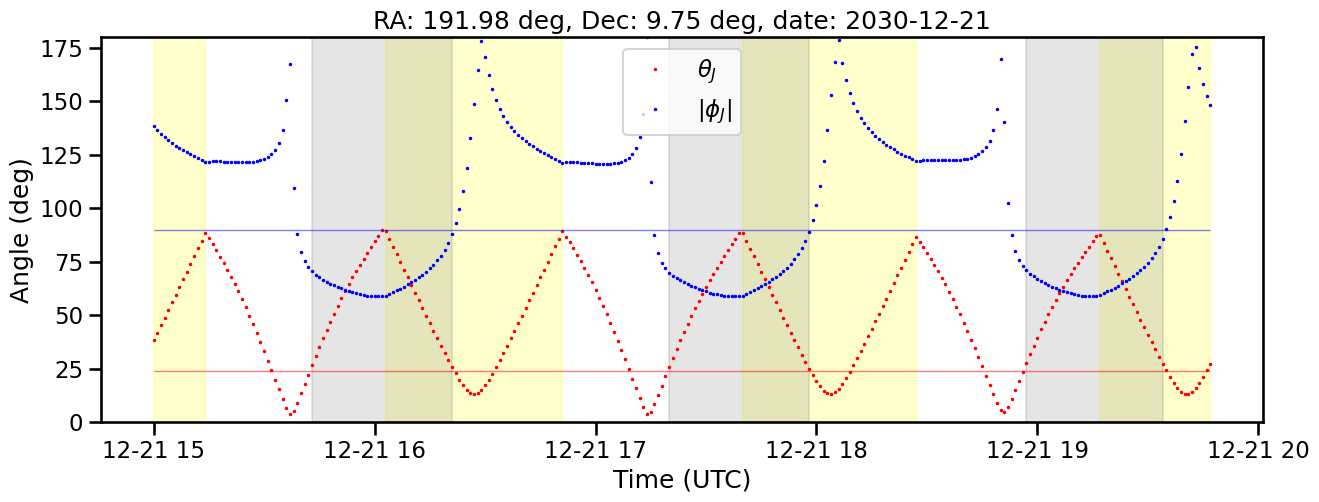

In [8]:
import matplotlib.pyplot as plt
from jasmine_orbit.GraphOrbit import get_true_segments

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times_array, toSatZn, '.', color="r", markersize=3, alpha=1, label="$\\theta_J$")
#ax.plot(times_array[~mask_obs], toSatZn[~mask_obs], 'x', color="pink", markersize=3, alpha=1)
ax.plot(times_array, np.abs(toSatAz), '.', color="b", markersize=3, alpha=1, label="$|\\phi_J|$")
#ax.plot(times_array[mask_thermal], np.abs(toSatAz)[mask_thermal], 'x', color="lightblue", markersize=3, alpha=1)

for start_idx, end_idx in get_true_segments(mask_obs):
    ax.axvspan(times_array[start_idx], times_array[end_idx], color="yellow", alpha=0.2)

for start_idx, end_idx in get_true_segments(mask_thermal):
    ax.axvspan(times_array[start_idx], times_array[end_idx], color="grey", alpha=0.2)


ax.hlines(CONFIG.THERMAL_Zn_MAX_DEG, times_array[0], times_array[-1], lw=1, color="r", alpha=0.5)
ax.hlines(CONFIG.THERMAL_Az_MAX_DEG, times_array[0], times_array[-1], lw=1, color="b", alpha=0.5)

ax.legend()
ax.set(title=f"RA: {skycoord_target.ra.degree:.2f} deg, Dec: {skycoord_target.dec.degree:.2f} deg, date: {times_array[0].strftime('%Y-%m-%d')}")
ax.set(xlabel="Time (UTC)", ylabel="Angle (deg)")
ax.set(ylim=(0,180))#, xlim=(times_plot[100000],times_plot[100300]))
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_979018/3583661263.py:3: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(times_array, -np.cos(alpha + np.deg2rad(toSatZn)), '.', color="r", markersize=3, alpha=1, label="$-\cos(\\alpha+\\theta_J)$")
/tmp/ipykernel_979018/3583661263.py:4: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(times_array, np.cos(np.deg2rad(toSatAz)), '.', color="b", markersize=3, alpha=1, label="$\cos(\phi_J)$")


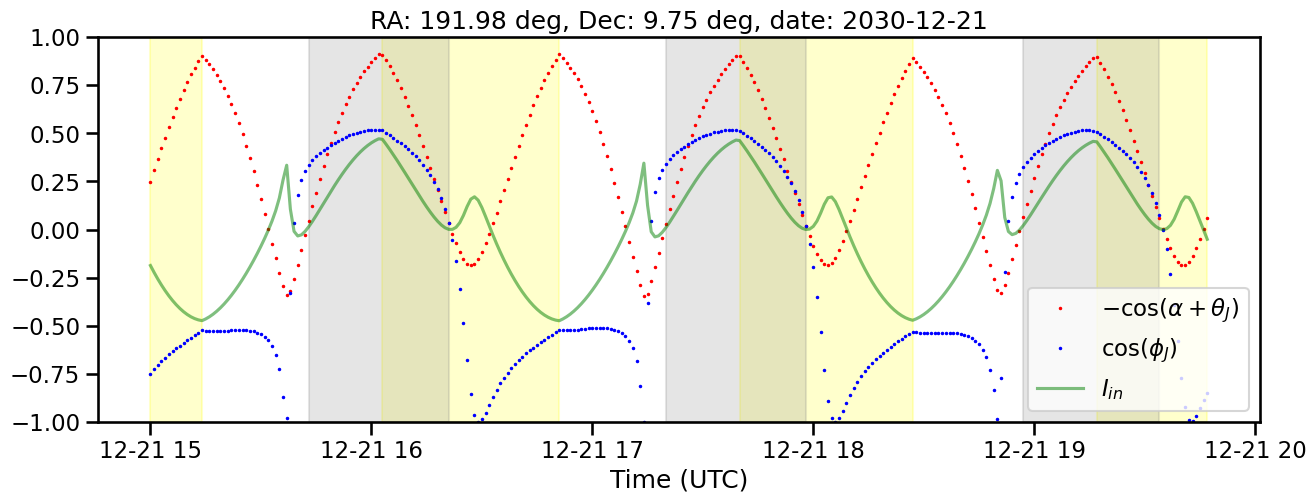

In [9]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times_array, -np.cos(alpha + np.deg2rad(toSatZn)), '.', color="r", markersize=3, alpha=1, label="$-\cos(\\alpha+\\theta_J)$")
ax.plot(times_array, np.cos(np.deg2rad(toSatAz)), '.', color="b", markersize=3, alpha=1, label="$\cos(\phi_J)$")
ax.plot(times_array, -np.cos(alpha + np.deg2rad(toSatZn)) * np.cos(np.deg2rad(toSatAz)), color="green", alpha=0.5, label="$I_{in}$")

for start_idx, end_idx in get_true_segments(mask_obs):
    ax.axvspan(times_array[start_idx], times_array[end_idx], color="yellow", alpha=0.2)

for start_idx, end_idx in get_true_segments(mask_thermal):
    ax.axvspan(times_array[start_idx], times_array[end_idx], color="grey", alpha=0.2)


ax.legend()
ax.set(title=f"RA: {skycoord_target.ra.degree:.2f} deg, Dec: {skycoord_target.dec.degree:.2f} deg, date: {times_array[0].strftime('%Y-%m-%d')}")
ax.set(xlabel="Time (UTC)")
ax.set(ylim=(-1.,1.))#, xlim=(times_plot[100000],times_plot[100300]))
plt.show()

In [10]:
"""
filename = f"/Users/yuikasagi/Jasmine/analysis/orbit202411_ktz/output/{args["-t"]}_{times[0].strftime('%Y-%m-%d')}_orbit3d.npz"
data = np.load(filename)
BarytoSat_ecliptic, toTgt, mask_obs, mask_thermal = data["BarytoSat_ecliptic"], data["toTgt"], data["mask_obs"], data["mask_thermal"]
"""

'\nfilename = f"/Users/yuikasagi/Jasmine/analysis/orbit202411_ktz/output/{args["-t"]}_{times[0].strftime(\'%Y-%m-%d\')}_orbit3d.npz"\ndata = np.load(filename)\nBarytoSat_ecliptic, toTgt, mask_obs, mask_thermal = data["BarytoSat_ecliptic"], data["toTgt"], data["mask_obs"], data["mask_thermal"]\n'

3次元で視覚化

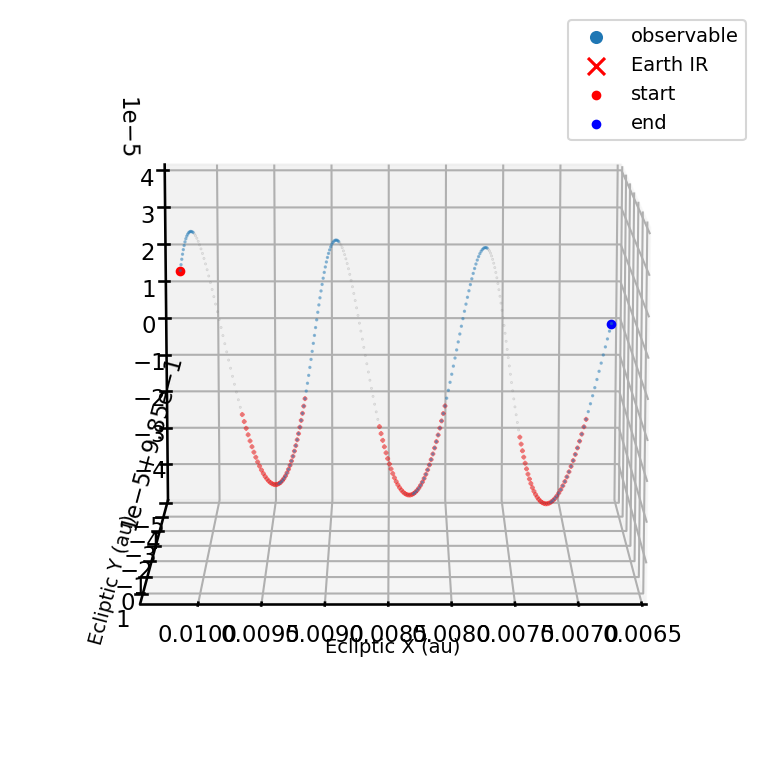

In [11]:
from jasmine_orbit.GraphOrbit import plot_orbit_3d

ind_str = 0 #129600
ind_end = -1 #130000
plot_orbit_3d(BarytoSat_ecliptic[ind_str:ind_end], toTgt[ind_str:ind_end], mask_obs[ind_str:ind_end], mask_thermal[ind_str:ind_end], outfile=None, view_angle=[10, 90, 0])#outfile)

熱入力量の指標の推移

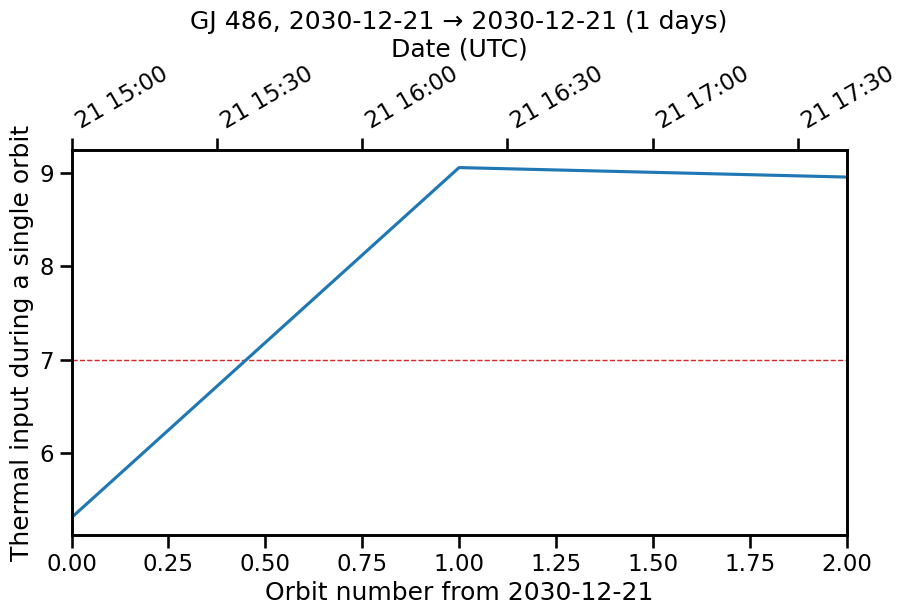

In [12]:
from jasmine_orbit.GraphOrbit import plot_frac_themalfeasibility

plot_frac_themalfeasibility(times, index_an, frac_obs, sum_thermal_input, target_name, outfile=None)

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_979018/10765059.py:8: SyntaxWarning: invalid escape sequence '\m'
  ax.set(xlabel=f"Date ({str(times[0].tzinfo)})", ylabel="Thermal Input ($I_\mathrm{in}$)")


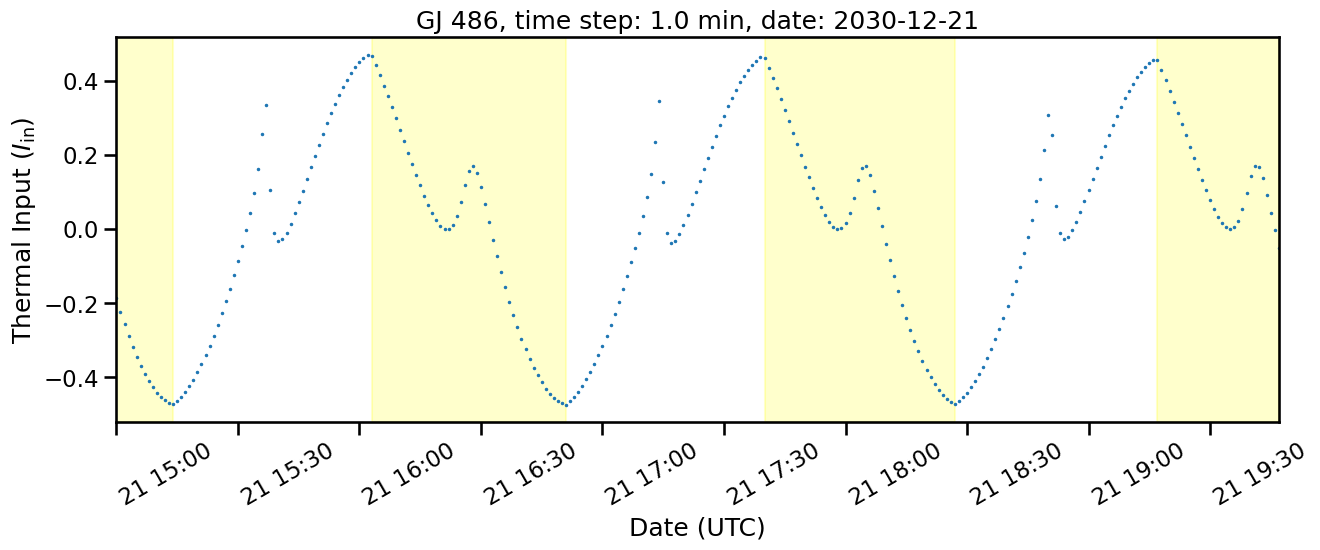

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(times_array, thermal_input, '.', color="C0", markersize=3, alpha=1, label="thermal input")
for start_idx, end_idx in get_true_segments(mask_obs):
    ax.axvspan(times_array[start_idx], times_array[end_idx], color="yellow", alpha=0.2)
    
ax.set(xlim=(times_array[0], times_array[-1]))
ax.set(title=f"{args['-t']}, time step: {args['-m']} min, date: {times_array[0].strftime('%Y-%m-%d')}")
ax.set(xlabel=f"Date ({str(times[0].tzinfo)})", ylabel="Thermal Input ($I_\mathrm{in}$)")
plt.setp(ax.get_xticklabels(), rotation=30, ha="left")
#plt.show()
outfile = "./output/figs/Iin_variation.png"
#plt.savefig(outfile, bbox_inches="tight")